In [1]:
import numpy as np
from PIL import Image
import scipy.misc
import torch
import matplotlib.pyplot as plt
import cv2


In [2]:
def extract_ampl_phase(fft_im):
    # fft_im: size should be bx3xhxwx2
    fft_amp = fft_im[:,:,:,:,0]**2 + fft_im[:,:,:,:,1]**2
    fft_amp = torch.sqrt(fft_amp)
    fft_pha = torch.atan2( fft_im[:,:,:,:,1], fft_im[:,:,:,:,0] )
    return fft_amp, fft_pha

def low_freq_mutate( amp_src, amp_trg, L=0.1 ):
    _, _, h, w = amp_src.size()
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)     # get b
    amp_src[:,:,0:b,0:b]     = amp_trg[:,:,0:b,0:b]      # top left
    amp_src[:,:,0:b,w-b:w]   = amp_trg[:,:,0:b,w-b:w]    # top right
    amp_src[:,:,h-b:h,0:b]   = amp_trg[:,:,h-b:h,0:b]    # bottom left
    amp_src[:,:,h-b:h,w-b:w] = amp_trg[:,:,h-b:h,w-b:w]  # bottom right
    return amp_src

def low_freq_mutate_np( amp_src, amp_trg, L=0.1 ):
    a_src = np.fft.fftshift( amp_src, axes=(-2, -1) )
    a_trg = np.fft.fftshift( amp_trg, axes=(-2, -1) )

    _, h, w = a_src.shape
    b = (  np.floor(np.amin((h,w))*L)  ).astype(int)
    c_h = np.floor(h/2.0).astype(int)
    c_w = np.floor(w/2.0).astype(int)

    h1 = c_h-b
    h2 = c_h+b+1
    w1 = c_w-b
    w2 = c_w+b+1

    a_src[:,h1:h2,w1:w2] = a_trg[:,h1:h2,w1:w2]
    a_src = np.fft.ifftshift( a_src, axes=(-2, -1) )
    return a_src

def FDA_source_to_target(src_img, trg_img, L=0.1):
    # exchange magnitude
    # input: src_img, trg_img

    # get fft of both source and target
    fft_src = torch.rfft( src_img.clone(), signal_ndim=2, onesided=False ) 
    fft_trg = torch.rfft( trg_img.clone(), signal_ndim=2, onesided=False )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = extract_ampl_phase( fft_src.clone())
    amp_trg, pha_trg = extract_ampl_phase( fft_trg.clone())

    # replace the low frequency amplitude part of source with that from target
    amp_src_ = low_freq_mutate( amp_src.clone(), amp_trg.clone(), L=L )

    # recompose fft of source
    fft_src_ = torch.zeros( fft_src.size(), dtype=torch.float )
    fft_src_[:,:,:,:,0] = torch.cos(pha_src.clone()) * amp_src_.clone()
    fft_src_[:,:,:,:,1] = torch.sin(pha_src.clone()) * amp_src_.clone()

    # get the recomposed image: source content, target style
    _, _, imgH, imgW = src_img.size()
    src_in_trg = torch.irfft( fft_src_, signal_ndim=2, onesided=False, signal_sizes=[imgH,imgW] )

    return src_in_trg

def FDA_source_to_target_np( src_img, trg_img, L=0.1 ):
    # exchange magnitude
    # input: src_img, trg_img

    src_img_np = src_img #.cpu().numpy()
    trg_img_np = trg_img #.cpu().numpy()

    # get fft of both source and target
    fft_src_np = np.fft.fft2( src_img_np, axes=(-2, -1) )
    fft_trg_np = np.fft.fft2( trg_img_np, axes=(-2, -1) )

    # extract amplitude and phase of both ffts
    amp_src, pha_src = np.abs(fft_src_np), np.angle(fft_src_np)
    amp_trg, pha_trg = np.abs(fft_trg_np), np.angle(fft_trg_np)

    # mutate the amplitude part of source with target
    amp_src_ = low_freq_mutate_np( amp_src, amp_trg, L=L )

    # mutated fft of source
    fft_src_ = amp_src_ * np.exp( 1j * pha_src )

    # get the mutated image
    src_in_trg = np.fft.ifft2( fft_src_, axes=(-2, -1) )
    src_in_trg = np.real(src_in_trg)

    return src_in_trg


In [20]:
im_src = Image.open("source.png").convert('RGB')
im_trg = Image.open("target.png").convert('RGB')

im_src = im_src.resize( (1024,512), Image.BICUBIC )
im_trg = im_trg.resize( (1024,512), Image.BICUBIC )

im_src = np.asarray(im_src, np.float32)
im_trg = np.asarray(im_trg, np.float32)

im_src = im_src.transpose((2, 0, 1))
im_trg = im_trg.transpose((2, 0, 1))

src_in_trg = FDA_source_to_target_np( im_src, im_trg, L=0 )

src_in_trg = src_in_trg.transpose((1,2,0))
src_in_trg = np.clip(src_in_trg,0,255).astype(np.uint8)
# scipy.misc.toimage(src_in_trg, cmin=0.0, cmax=255.0).save('demo_images/src_in_tar.png')

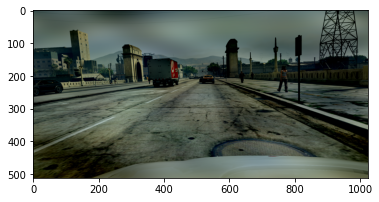

In [21]:
plt.imshow(src_in_trg)

194.092535044095